In [1]:
import decode
import decode.utils
import decode.neuralfitter.train.live_engine

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print(f"DECODE version: {decode.utils.bookkeeping.decode_state()}")

DECODE version: vINVALID-recent-0.10.0


# DECODE - Training

This notebook highlights how to generate a training parameter file and
train a DECODE model for fitting experimental data.

The DECODE model is trained on simulated data. This requires a calibration spline based PSF model,
and a parameter file that contains camera settings and other hyper parameters to set up the simulation process.

While we provide an example calibration file here to demonstrate the training procedure you will have to create one yourself for your own data.

If you plan to use DECODE regularly you should take a look at the generated parameter file at the end of this notebook
and will recognise that it just holds a couple of parameters and paths. You will want to adjust these
to your data by creating or modifying the .yaml file directly.
After that you can start the training directly (see the last section of this notebook).
Alternatively, SMAP can create this parameter file for you (please consult the documentation for that).


## Set parameters
Set device for training. We **do not recommend training on CPU** since this will be quite slow. If you train on CPU though, you may want to change the number of threads if you have a big machine (see below).

In [2]:
device = 'cuda:0'  # or 'cpu'
device_ix = 0  # possibly change device index (only for cuda)
threads = 4  #  number of threads, useful for CPU heavy computation. Change if you know what you are doing.
worker = 4  # number of workers for data loading. Change only if you know what you are doing.

torch.set_num_threads(threads)  # set num threads

if device != 'cpu':
    if (not torch.cuda.is_available()) or (not decode.simulation.psf_kernel.CubicSplinePSF.cuda_is_available()):
        raise ValueError("You have selected a non CPU device, but CUDA is not available."
                         "Refer to CPU version or check your installation.")

If you have manually downloaded the example package *(experimental_data_workflow)* you can specify
the root directory of the .zip in the path variable below. Otherwise, the package will be
loaded/reloaded.

In [3]:
# load example calibration file from server (this can be skipped)
gateway = decode.utils.example_helper.load_gateway()

# dir where to store example data, leave as '' to store in current folder
path = Path('')

# change here for other files
package = gateway['examples']['experimental_data_workflow']

# get paths to files
zip_folder = decode.utils.example_helper.load_example_package(
    path=(path / package['name']).with_suffix('.zip'), url=package['url'], hash=package['hash'])

#calib_file = str(zip_folder / 'spline_calibration_3dcal.mat')

## Bead calibration

To obtain the calibration file a spline model is fit on a stack of beads.
We recommend to use fit3Dspline which is part of the SMAP package.

1. Install the stand-alone version of SMAP from [www.rieslab.de](www.rieslab.de) or if you have Matlab, downlowd the source-code from [www.github.com/jries/SMAP](www.github.com/jries/SMAP). There, you also find the installation instructions and Documentation.
2. Acquire z-stacks with fluorescent beads (e.g. 100 nm beads). We typcally use a z-range of +/- 750 nm and a step size of 10-50 nm.
3. In SMAP, use the plugin *calibrate3DSplinePSF* to generate the calibartion file. In the user guide (accessible from the SMAP help menu) in section 5.4, this is explained in detail. Further information about the calibration process can be found in [Li et al, Nature Methods (2018)](https://doi.org/10.1038/nmeth.4661).

In [3]:
# uncomment and exectue only if you have not executed the example download cell above
calib_file = 'zStack-25nm_3dcal.mat'

## Simulation Parameters

To set the simulation parameters we load the default config file and go through the settings

In [4]:
# copy default parameter files which are then changed as specified
decode.utils.param_io.copy_reference_param('')  # saved in current dir

In [5]:
param = decode.utils.param_io.load_params('param_friendly.yaml')  # change path if you load custom file

param.Hardware.device = device
param.Hardware.device_ix = device_ix
param.Hardware.device_simulation = device
param.Hardware.torch_threads = threads
param.Hardware.num_worker_train = worker

The camera parameters need to be adjusted according to the device used. Here we used an EMCCD camera, for a sCMOS device you must set the em_gain to None.

In [6]:
param.Camera.baseline = 500
param.Camera.e_per_adu = 3.0
param.Camera.em_gain = 20
param.Camera.px_size =[160.0, 160.0] # Pixel Size in nano meter
param.Camera.qe = 0.95                # Quantum efficiency
param.Camera.read_sigma = 45
param.Camera.spur_noise = 0

param.Camera.to_dict()

{'baseline': 500,
 'e_per_adu': 3.0,
 'em_gain': 20,
 'px_size': [160.0, 160.0],
 'read_sigma': 45,
 'spur_noise': 0,
 'convert2photons': True,
 'qe': 0.95}

The simulation parameters should be set so that the resulting simulated frames resemble real frames as closely as possible.
You can use SMAP to infer these parameters by performing inference with an iterative approach on a couple of frames:

1. Use the bead calibration to fit your SMLM data.
2. Use the plugin: *DECODE\_training\_estimates* to estimate the photo-physical parameters of the experiment and to save them into a parameter file. Consult the information of the plugin (accessible via the Info button) for further information.

However it is also possible to find reasonable values by hand which we do now.

In [17]:
param.Simulation.bg_uniform = [20.0, 200.0]           # background range to sample from. You can also specify a const. value as 'bg_uniform = 100'
param.Simulation.emitter_av = 50                      # Average number of emitters per frame
param.Simulation.emitter_extent[2] = [-400, 400]    # Volume in which emitters are sampled. x,y values should not be changed. z-range (in nm) should be adjusted according to the PSF
param.Simulation.intensity_mu_sig = [7000.0, 3000.0]  # Average intensity and its standard deviation
param.Simulation.lifetime_avg = 1.                     # Average lifetime of each emitter in frames. A value between 1 and 2 works for most experiments

param.Simulation.to_dict()

{'bg_uniform': [20.0, 200.0],
 'emitter_av': 50,
 'emitter_extent': [[-0.5, 39.5], [-0.5, 39.5], [-400, 400]],
 'intensity_mu_sig': [7000.0, 3000.0],
 'lifetime_avg': 1.0,
 'density': None,
 'img_size': [40, 40],
 'intensity_th': None,
 'mode': 'acquisition',
 'photon_range': None,
 'psf_extent': [[-0.5, 39.5], [-0.5, 39.5], None],
 'roi_size': None,
 'roi_auto_center': False,
 'xy_unit': 'px'}

Lastly we provide the path to the calibration file, and to the output destination.
There are more parameters (you can just execute param in a cell to look at them) that you should not need to change.
You might have to reduce the batch size (param.HyperParameter.batch_size) if you run out of memory.

In [18]:
param.InOut.calibration_file = calib_file
param.InOut.experiment_out = ''

param.InOut.to_dict()

{'calibration_file': 'zStack-25nm_3dcal.mat',
 'experiment_out': '',
 'checkpoint_init': None,
 'model_init': None}

Now we can set up our simulator and the camera model.

In [19]:
simulator, sim_test = decode.neuralfitter.train.live_engine.setup_random_simulation(param)
camera = decode.simulation.camera.Photon2Camera.parse(param)

In [20]:
# finally we derive some parameters automatically for easy use
param = decode.utils.param_io.autoset_scaling(param)

Let us sample a set frames, and also load our data:

In [21]:
tar_em, sim_frames, bg_frames = simulator.sample()
sim_frames = sim_frames.cpu()

frame_path = 'P1-Cy3b_001.tif'  # change if you load your own data
data_frames = decode.utils.frames_io.load_tif(frame_path).cpu()

print(f'Data shapes, simulation: {sim_frames.shape}, real data: {data_frames.shape}')
print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Data shapes, simulation: torch.Size([10001, 40, 40]), real data: torch.Size([5000, 300, 300])
Average value, simulation: 194.0, real data: 856.0


Looking at the mean brightness, we see that there is a large missmatch.
The reason is that we simulate the photons that are emitted by the fluorophores, while the tiff file shows the photons that are recorded by the camera (after amplificiation).
To enable direct comparison we convert the real data frames into photon numbers.
Be aware that camera.forward() and camera.backward() are not each others exact inverse. forward()
performs noise sampling, while backward() simply converts camera units back to expected photon
numbers by the respective statistical means.

In [22]:
data_frames = camera.backward(data_frames, device='cpu')
print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Average value, simulation: 194.0, real data: 56.0


By comparing random frames (chosing a dense region of the real data) we can convince ourselves that the distributions are somewhat similar.
If you observe large differences for your dataset, you probably have to adjust param.Simulation.bg_uniform and param.Simulation.intensity_mu_sig

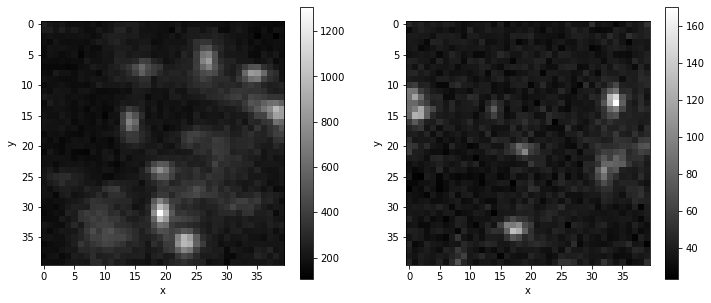

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(121)
decode.plot.PlotFrame(sim_frames[torch.randint(0, len(sim_frames), size=(1, ))]).plot()
plt.colorbar()

plt.subplot(122)
decode.plot.PlotFrame(data_frames[torch.randint(0, len(data_frames), size=(1, )), 30:70,-40:]).plot()
plt.colorbar()

plt.show()

**Note:** If your available (i.e. free) GPU memory is lower than 6GB you will likely run into memory errors. Check your total GPU memory on the set device by running the cell below.
To avoid this you can lower the batch_size to 32 to 16. However you should have at least a 4GB GPU available. You might be able to run training on a smaller GPU using very small batch sizes but this will negatively impact performance.

**Note:** If other processes or a screen attached to the GPU you want to train on consumes GPU resources, the free GPU memory might be significantly lower than the total GPU memory size.

In [30]:
if device != 'cpu':
    mem_gb = torch.cuda.get_device_properties(device).total_memory / 1e9
    print(f"Your approximate total GPU memory size on the set device {device} is {mem_gb:.2f} GB.")

param.HyperParameter.batch_size = 16

Your approximate total GPU memory size on the set device cuda:0 is 4.29 GB.


Once you are happy with you settings you can write the parameters to a file (or edit the param_friendly.yaml directly)

In [31]:
param_out_path = 'param_friendly.yaml' # or an alternative path
decode.utils.param_io.save_params(param_out_path, param)

# Start the Actual Training of the Model
To start training we recommend to start it from a new terminal window/Anaconda prompt as this is most stable. So please open up a new terminal, activate the respective environment and start the training.

    conda activate decode_env
    cd [directory where this notebook is]
    python -m decode.neuralfitter.train.live_engine -p notebook_example.yaml  # change path if you modified it

You can end training at any point by killing the associated process if you think that the model has converged. The current network is stored after every epoch.
You can also continue training (for example in case of crash) by setting the param.InOut.checkpoint_init parameter to the path of the ckpt.pt of the training run.

In case you experience multiprocessing issues, please consult our FAQ in our documentation (https://decode.readthedocs.io/). You may run the command above with the additional `-w 0` flag.

To check training progress you may start a tensorboard instance. Again, please open a new terminal instance and navigate (within the terminal, in a new terminal window/tab) to the directory of this notebook and start tensorboard. Don't forget to activate the conda environment before starting tensorboard.

    cd [directory which containts 'runs', i.e. this notebook's path]
    conda activate decode_env
    tensorboard --samples_per_plugin images=100 --port=6006 --logdir=runs

Open it in your browser: http://localhost:6006
Numereous evaluation metrics are tracked here. Under the 'Images' header you can see example frames and localizations.
Keep in mind though that these are all calculated on the simulated data. So you can check whether the training has converged,
but you'll have to run the model on the actual data to see if you set the parameters correctly.

For that open the Fit.ipynb notebook.